# __PREPROCESSING__

In [1]:
!pip install pyarrow

import pandas as pd
import seaborn as sns
import numpy as np
import random
import re
import os

SAMPLE_SIZE = 500000

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class Dataset:
    def __init__(self, file:str):
        self.file_name : str = file
        self.types : dict = self.load_types()
        self.df : pd.DataFrame = None
        
    def name(self):
        return re.search(r'\/([\w\d]*)\.csv',self.file_name).group(1)
    
    def __types_file__(self):
        return 'types/' + self.name() +'.npy'
        
    def save_types(self):
        np.save(self.__types_file__(), self.types)
        
    def load_types(self):
        if os.path.isfile(self.__types_file__()):
            self.types = np.load(self.__types_file__(),allow_pickle='TRUE').item()
            return self.types
        return None
    
    def col(self,columns:list, index:bool=True,**pd_params)->pd.DataFrame:
        """Loads some columns of the dataframe out of the whole csv file
        
        :param columns: a list of the desired columns
        :type columns: list
        :param index: if True loads also the 'sid' column as the index
        :type index: bool
        :param **pd_params: any other params for pd.read_csv(...)
        :rtype: pd.DataFrame
        """
        col_list = columns
        if 'cts' in col_list:
            pd_params['parse_dates'] = ['cts']
        if index :
            col_list.append('sid')
        return pd.read_csv(self.file_name,
                           usecols=col_list,
                           dtype=self.types, 
                           index_col='sid' if index else None,
                           delimiter='\t', 
                           **pd_params)

datasets = [
    Dataset(file='instagram-dataset/instagram_profiles.csv'), 
    Dataset(file='instagram-dataset/instagram_locations.csv'), 
    Dataset(file='instagram-dataset/instagram_posts.csv')
]
profiles, locations, posts = datasets

In [3]:
profiles.types = {
#     'sid' : int,
    'profile_id' : int,
    'profile_name' : pd.StringDtype(storage='pyarrow'),
    'firstname_lastname' : pd.StringDtype(storage='pyarrow'),
    'description' : pd.StringDtype(storage='pyarrow'),
    'following' : int,
    'followers' : int,
    'n_posts' : int,
    'url' : pd.StringDtype(storage='pyarrow'),
#     'cts' : pd.DatetimeTZDtype(tz='UTC'), #obtained through parse_dates=['cts']
    'is_business_account' : pd.BooleanDtype()
}
posts.types = {
#     'sid' : int, # gives an error, maybe because it's the index?
    'sid_profile' : int,
    'post_id' : pd.StringDtype(storage='pyarrow'),
    'profile_id' : int,
    'location_id' : int,
    'description' : pd.StringDtype(storage='pyarrow'),
    'post_type' : pd.CategoricalDtype(categories=[1,2,3]),
    'numbr_likes' : int,
    'number_comments' : int
}
locations.types = {
#     'sid' : int, # gives an error, maybe because it's the index?
    'id' : int,
    'name' : pd.StringDtype(storage='pyarrow'),
    'street' : pd.StringDtype(storage='pyarrow'),
    'zip' : pd.StringDtype(storage='pyarrow'),
    'city' : pd.StringDtype(storage='pyarrow'),
    'region' : pd.StringDtype(storage='pyarrow'),
    'cd' : pd.CategoricalDtype(),
    'phone' : pd.StringDtype(storage='pyarrow'),
    'aj_exact_city_match' : pd.BooleanDtype(),
    'aj_exact_country_match' : pd.BooleanDtype(),
    'blurb' : pd.StringDtype(storage='pyarrow'),
    'dir_city_id' : pd.StringDtype(storage='pyarrow'),
    'dir_city_name' : pd.StringDtype(storage='pyarrow'),
    'dir_city_slug' : pd.StringDtype(storage='pyarrow'),
    'dir_country_id' : pd.CategoricalDtype(),
    'dir_country_name' : pd.CategoricalDtype(),
    'lat' : pd.Float32Dtype(),
    'lng' : pd.Float32Dtype(),
    'primary_alias_on_fb' : pd.StringDtype(storage='pyarrow'),
    'slug' : pd.StringDtype(storage='pyarrow'),
    'website' : pd.StringDtype(storage='pyarrow'),
}

In [4]:
def get_types(signed=True, unsigned=True, custom=[]):
    '''Returns a pandas dataframe containing the boundaries of each integer dtype'''
    # based on https://stackoverflow.com/a/57894540/9419492
    pd_types = custom
    if signed:
        pd_types += [pd.Int8Dtype() ,pd.Int16Dtype() ,pd.Int32Dtype(), pd.Int64Dtype()]
    if unsigned:
        pd_types += [pd.UInt8Dtype() ,pd.UInt16Dtype(), pd.UInt32Dtype(), pd.UInt64Dtype()]
    type_df = pd.DataFrame(data=pd_types, columns=['pd_type'])
    type_df['np_type'] = type_df['pd_type'].apply(lambda t: t.numpy_dtype)
    type_df['min_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).min)
    type_df['max_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).max)
    type_df['allow_negatives'] = type_df['min_value'] < 0
    type_df['size'] = type_df['np_type'].apply(lambda row: row.itemsize)
    type_df.sort_values(by=['size', 'allow_negatives'], inplace=True)
    return type_df.reset_index(drop=True)
    
get_types()

def downcast_int(file_path, column:str, chunksize=10000, delimiter=',', signed=True, unsigned=True):
    '''Assigns the smallest possible dtype to an integer column of a csv'''
    types = get_types(signed, unsigned)
    negatives = False
    for chunk in pd.read_csv(file_path, usecols=[column],delimiter=delimiter,chunksize=chunksize):
        M = chunk[column].max()
        m = chunk[column].min()
        if not signed and not negatives and m < 0 :
            types = types[types['allow_negatives']] # removes unsigned rows
            negatives = True
        if m < types['min_value'].iloc[0]:
            types = types[types['min_value'] < m]
        if M > types['max_value'].iloc[0]:
            types = types[types['max_value'] > M]
        if len(types) == 1:
            print('early stop')
            break
    return types['pd_type'].iloc[0]

def optimize_cols(file, int_cols, delimiter=',', signed=True, unsigned=True):
    out = dict()
    for col in int_cols:
        out[col] = downcast_int(file, col, delimiter=delimiter, signed=signed, unsigned=unsigned)
    return out

In [5]:
for ds in datasets:
    if not ds.load_types():
        int_cols = [k for k,v in ds.types.items() if v is int]
        print(int_cols)
        ds.types.update(optimize_cols(ds.file_name, int_cols, delimiter='\t'))
        print(f'Optimized {len(int_cols)} types for {ds.name()}')
#     ds.types.update({k:pd.StringDtype(storage='pyarrow') for k,v in ds.types.items() if v==pd.StringDtype(storage='pyarrow')})
    ds.save_types()
#     print(ds.types)

for ds in datasets:
    ds.df = pd.read_csv(ds.file_name, dtype=ds.types, index_col='sid', delimiter='\t', parse_dates=['cts'], nrows=SAMPLE_SIZE)
    avg_mem_unoptimized = pd.read_csv(ds.file_name, index_col='sid', delimiter='\t', nrows=SAMPLE_SIZE).memory_usage(deep=True).sum()/SAMPLE_SIZE
    avg_mem_optimized = ds.df.memory_usage(deep=True).sum()/SAMPLE_SIZE
    print(f'{ds.name().ljust(19)} mean optimized memory usage per entry:  {round(avg_mem_optimized):3} B vs {round(avg_mem_unoptimized):4} B  : {round(avg_mem_optimized/avg_mem_unoptimized*100,2):5}%') 

instagram_profiles  mean optimized memory usage per entry:  199 B vs  552 B  : 36.14%
instagram_locations mean optimized memory usage per entry:  280 B vs 1134 B  :  24.7%
instagram_posts     mean optimized memory usage per entry:  275 B vs  749 B  : 36.69%


# __RISPOSTE DOMANDE__

### __COLONNE DATASETS__

| Locations | Posts | Profiles |
| :-: | :-: | :-: |
| sid | sid | sid
| id | sid_profile | profile_id
| name | post_id | profile_name
| street | profile_id | firstname_lastname
| zip | location_id | description
| city | cts | following
| region | post_type | followers
| cd | description | n_posts
| phone | numbr_likes | url
| aj_exact_city_match | number_comments | cts


***
__1 - [RQ1] After collecting information, the Data Scientists have to know what dataset they are dealing with, so let's start with an Exploratory Data Analysis (EDA). What can you say about our datasets? Please summarise its main characteristics with visual and tabular methods.__
***

As an initial step we can start by displaying the first 5 lines of the 3 datasets to have an idea of what we are dealing with

Locations dataset:

In [6]:
locations.df.head()

,id,name,street,zip,city,region,cd,phone,aj_exact_city_match,aj_exact_country_match,...,dir_city_name,dir_city_slug,dir_country_id,dir_country_name,lat,lng,primary_alias_on_fb,slug,website,cts
sid,,,,,,,,,,,,,,,,,,,,,
719981,110296492939207,"Playa de Daimuz - Valencia, España",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,...,<NA>,<NA>,NaN,NaN,-0.139475,38.974392,daimuzplaya,playa-de-daimuz-valencia-espana,https://es.wikipedia.org/wiki/Daimuz,2019-05-29 01:21:29.987
719983,274391278,Nová Vieska,<NA>,<NA>,Nová Vieska,<NA>,SK,<NA>,True,False,...,Kis-Újfalu,kis-ujfalu,SK,Slovakia,18.466667,47.866669,<NA>,nova-vieska,<NA>,2019-05-29 01:21:38.037
719985,148885595789195,Everest Today,Himalayas,+977,"Kathmandu, Nepal",<NA>,NP,<NA>,False,False,...,Pasupati,pasupati,NP,Nepal,85.330147,27.70196,EverestToday,everest-today,<NA>,2019-05-29 01:21:46.295
719987,263258277,BULAC - Bibliothèque universitaire des langues...,"65, rue des Grands-Moulins",75013,"Paris, France",<NA>,FR,01 81 69 18 00,False,False,...,13ème Arrondissement Paris,13eme-arrondissement-paris,FR,France,2.375995,48.82724,BULAC.Paris,bulac-bibliotheque-universitaire-des-langues-e...,www.bulac.fr,2019-05-29 01:21:54.355
326443,406147529857708,ABC Cable Networks Group,3800 W Alameda Ave,91505,"Burbank, California",<NA>,US,(818) 569-7500,False,False,...,<NA>,<NA>,NaN,NaN,-118.341866,34.153267,<NA>,abc-cable-networks-group,<NA>,2019-04-02 15:22:55.703


***

Posts dataset:

In [7]:
posts.df.head()

,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
sid,,,,,,,,,
28370919,3496776,BXdjjUlgcgq,2237947779,1022366247837915,2017-08-06 20:06:57,2,Wreckloose! Deevalley bike park laps on the @i...,80,0
28370932,-1,BVg0pbolYBC,5579335020,457426771112991,2017-06-19 09:31:16,1,🙌🏼 believe in ya dreams 🙌🏼 just like I believe...,25,1
28370933,-1,BRgkjcXFp3Q,313429634,457426771112991,2017-03-11 20:05:03,1,#meraviglia #incensi #the #candele #profumo #a...,9,0
28370934,-1,BKTKeNhjEA7,1837592700,457426771112991,2016-09-13 16:27:16,1,#teatime #scorpion #friends #love #mountains #...,4,0
28370935,-1,8-NQrvoYLX,1131527143,457426771112991,2015-10-18 10:19:27,1,thE sky gavE mE a #constEllation,8,0


Profiles dataset:

In [8]:
profiles.df.head()

,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account
sid,,,,,,,,,,
4184446,4721049632,jphillip033,John Pierce,"""Document Everything Always""",250,146,170,<NA>,2019-08-01 14:38:55.394000-04:00,False
4184457,590583002,mama_haas,Deanna,Trying to enjoy the simple things in life. Kni...,534,1145,2878,www.etsy.com/shop/MamaHaas69,2019-08-01 14:39:36.526000-04:00,False
4184460,1074146658,yellowlightbreen,Eliza Gray,Maine is for Lovers,469,324,431,elizajanegray.com,2019-08-01 14:39:54.407000-04:00,False
4184461,1472038842,tec1025,Thomas Clark,<NA>,<NA>,<NA>,<NA>,<NA>,2019-08-01 14:40:06.472000-04:00,<NA>
4184462,3531420803,luckyfluff,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2019-08-01 14:40:07.806000-04:00,<NA>



Now let's try to have a summary of the most important information of the three datasets starting with their dimensions (in terms of rows $\times$ columns)


In [60]:
print(f"Locations dataset --> {locations.df.shape}")
print(f"Posts dataset --> {posts.df.shape}")
print(f"Profiles dataset --> {profiles.df.shape}")

Locations dataset --> (500000, 22)
Posts dataset --> (500000, 9)
Profiles dataset --> (500000, 10)


We have three pretty big datasets, let's display the name of the variables (columns) for each of them with the information related to the number of "Non null" values and the type we have choose to assign to them.

Locations dataset:

In [10]:
locations.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 719981 to 404538
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      500000 non-null  UInt64        
 1   name                    500000 non-null  string        
 2   street                  352799 non-null  string        
 3   zip                     364715 non-null  string        
 4   city                    459638 non-null  string        
 5   region                  1239 non-null    string        
 6   cd                      460989 non-null  string        
 7   phone                   301423 non-null  string        
 8   aj_exact_city_match     489691 non-null  boolean       
 9   aj_exact_country_match  489691 non-null  boolean       
 10  blurb                   206724 non-null  string        
 11  dir_city_id             243737 non-null  string        
 12  dir_city_name           2

Posts dataset:

In [11]:
posts.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 28370919 to 28878522
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   sid_profile      500000 non-null  Int32         
 1   post_id          500000 non-null  string        
 2   profile_id       500000 non-null  UInt64        
 3   location_id      499994 non-null  UInt64        
 4   cts              500000 non-null  datetime64[ns]
 5   post_type        500000 non-null  category      
 6   description      458485 non-null  string        
 7   numbr_likes      500000 non-null  Int64         
 8   number_comments  500000 non-null  UInt32        
dtypes: Int32(1), Int64(1), UInt32(1), UInt64(2), category(1), datetime64[ns](1), string(2)
memory usage: 131.1 MB


Profiles dataset:

In [12]:
profiles.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 4184446 to 76885
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   profile_id           479953 non-null  UInt64 
 1   profile_name         500000 non-null  string 
 2   firstname_lastname   461740 non-null  string 
 3   description          275131 non-null  string 
 4   following            353624 non-null  UInt32 
 5   followers            353624 non-null  UInt32 
 6   n_posts              353624 non-null  UInt32 
 7   url                  127126 non-null  string 
 8   cts                  493661 non-null  object 
 9   is_business_account  350261 non-null  boolean
dtypes: UInt32(3), UInt64(1), boolean(1), object(1), string(4)
memory usage: 72.4+ MB


We can now start to compute some statistics

Let's start with the "Posts" dataset for which we choose the columns "numbr_likes" and "numbr_comments":

In [63]:
posts.df[["numbr_likes", "number_comments"]].describe()

,numbr_likes,number_comments
count,5.000000e+05,500000.000000
mean,3.253357e+02,7.690992
std,6.068892e+03,231.952096
min,0.000000e+00,0.000000
25%,1.900000e+01,0.000000
50%,4.700000e+01,1.000000
75%,1.260000e+02,5.000000
max,1.963123e+06,135221.000000


And now the "Profiles" dataset for which we choose "following", "followers" and "n_posts"

In [65]:
profiles.df[["following", "followers", "n_posts"]].describe()

,following,followers,n_posts
count,353624.000000,3.536240e+05,353624.000000
mean,1044.935069,6.607593e+03,546.849722
std,1413.880253,1.044236e+05,1127.570218
min,0.000000,0.000000e+00,0.000000
25%,276.000000,2.550000e+02,75.000000
50%,593.000000,6.430000e+02,232.000000
75%,1127.000000,1.625000e+03,608.000000
max,153651.000000,2.917680e+07,108785.000000


An important information to know when analyzing a dataset is the number of missing values for each variables. We already found the numbers of "Non null" but let's now visualize, trough a barplot for each dataset, which are the proportions of "NaN"

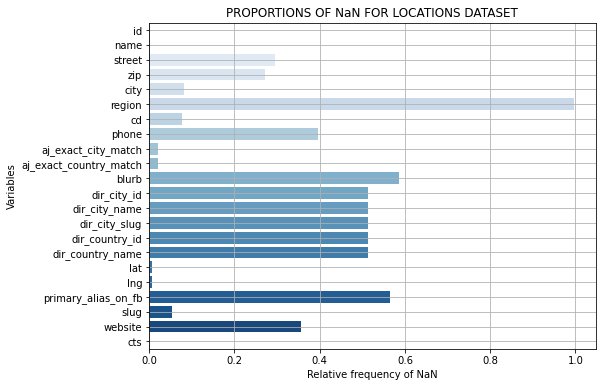

In [66]:
plt.rcParams['figure.figsize'] = [8,6]
sns.barplot(x=np.array(locations.df.isna().sum())/len(locations.df), y=locations.df.columns.values.tolist(), palette="Blues")
plt.title("PROPORTIONS OF NaN FOR LOCATIONS DATASET")
plt.xlabel("Relative frequency of NaN")
plt.ylabel("Variables")
plt.grid()

The barplot shows that for some variables we don't have around 50% of the observation, for the variable "region" this proportion it's much higher, we miss almost all the values.

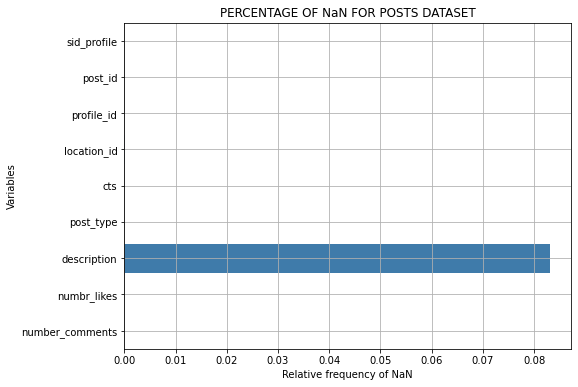

In [14]:
sns.barplot(x=np.array(posts.df.isna().sum())/len(posts.df), y=posts.df.columns.values.tolist(), palette="Blues")
plt.title("PROPORTIONS OF NaN FOR POSTS DATASET")
plt.xlabel("Relative frequency of NaN")
plt.ylabel("Variables")
plt.grid()

For this dataset we have very few _NaN_ and they are all present in the variable "Description"

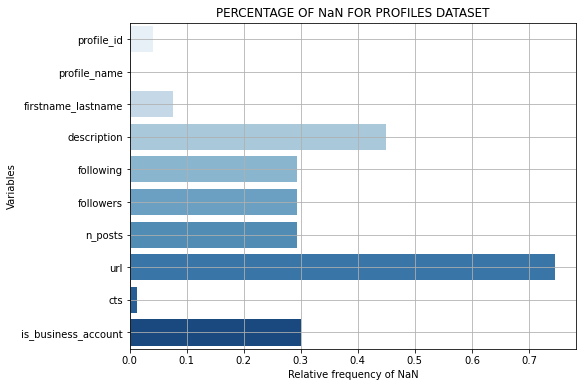

In [15]:
sns.barplot(x=np.array(profiles.df.isna().sum())/len(profiles.df), y=profiles.df.columns.values.tolist(), palette="Blues")
plt.title("PROPORTIONS OF NaN FOR PROFILES DATASET")
plt.xlabel("Relative frequency of NaN")
plt.ylabel("Variables")
plt.grid()

With this last barplot we can see that "following", "followers" and "n_posts" have the same percentage of _NaN_ and that "url" it's by far the variable with the most number of missing values. We miss a lot of values also for the variable "description" and "is_business_account"

Number likes and comments distribution (visualized with an histogram)

Number of followers, following and posts distribution (visualized with an histogram)

In [16]:
# sns.histplot(data=profiles.df, x="followers")

***

__4 - [RQ4] In most cases, we will not have a consistent dataset, and the one we are dealing with is not an exception (ex. in the given datasets, you may not find the information of the profiles for some of the posts). So let’s enhance our analysis.__

$\bullet$ Write a function that, given a profile_id, will be able to return the posts that belong to the given profile_id.

In [13]:
# andrà bene tutta la riga o vanno mostrate solo alcune colonne?
def post_finder(prof_id):
    posts_found = posts.df[posts.df["profile_id"]==prof_id]
    return posts_found[["profile_id", "post_id", "numbr_likes", "number_comments"]]
example = 5337907015
post_finder(example)

,profile_id,post_id,numbr_likes,number_comments
sid,,,,
28452682,5337907015,BxTV32ahahQ,15,2
28452667,5337907015,BsRarTBBPmd,30,6
28452668,5337907015,BqOlb0kBQ5V,25,5
28452669,5337907015,BtxQHmLhI1h,26,11
28452672,5337907015,Bic19O-liDj,28,0
28452673,5337907015,BsTLZELBTnU,28,0
28452674,5337907015,BqTsJM_FDQ_,28,0
28452675,5337907015,ByB_OFnnGFM,19,0
28452676,5337907015,BxxLqEyHlyg,24,0


$\bullet$ Write another function that, given an input n (an integer), will return the posts that belong to the n top posted profiles (top n profiles that have posted the highest number of posts) that their data is available in the profile.csv using the previously written function.

In [14]:
def top_posts_profiles(n):
    prof = posts.df["profile_id"].value_counts().head(int(n)).index.tolist()
    return posts.df.loc[posts.df['profile_id'].isin(prof), ["profile_id", "post_id", "numbr_likes", "number_comments"]]
example = 2
top_posts_profiles(example)

,profile_id,post_id,numbr_likes,number_comments
sid,,,,
28404265,195747313,BDoMh4AJCgy,16,3
28404261,195747313,BsjHQEEgVrf,17,2
15060919,195747313,Bv9Dym3ghIx,18,3
28404260,195747313,BAhulPSJChO,23,0
28404264,195747313,BTWZXBtD696,20,0
...,...,...,...,...
29226389,19980428,BHP3z-hjv9n,18,0
29226390,19980428,BHPsj0XDKVz,37,3
29226391,19980428,BHKpa_aDa8f,26,0


$\bullet$ What is the average number of "likes" and comments of the top 10 profiles with the highest number of posts which their information is available in profile.csv?

In [15]:
top10_profiles = posts.df["profile_id"].value_counts().head(int(10)).index.tolist()
for profile in top10_profiles:
    print(round(posts.df.loc[posts.df['profile_id'] == profile, ['numbr_likes', "number_comments"]].mean(),3))

numbr_likes        18.317
number_comments     1.000
dtype: float64
numbr_likes        37.525
number_comments     2.000
dtype: float64
numbr_likes        20.971
number_comments     1.647
dtype: float64
numbr_likes        43.176
number_comments     1.824
dtype: float64
numbr_likes        11.500
number_comments     0.647
dtype: float64
numbr_likes        26.788
number_comments     1.242
dtype: float64
numbr_likes        67.333
number_comments     1.667
dtype: float64
numbr_likes        53.667
number_comments    22.212
dtype: float64
numbr_likes        5.242
number_comments    0.000
dtype: float64
numbr_likes        18.848
number_comments     1.424
dtype: float64


$\bullet$ Plot the number of posts that these top 10 profiles have sent on Instagram in the given interval in question RQ3. Interpret the resulting chart.

In [ ]:
# semplicemente un istogramma

__7 - [RQ7] Of course, calculating probabilities is a job that any Data Scientist must know. So let's compute some engaging figures.__

$\bullet$ What's the probability that a post receives more than 20% "likes" of the number of followers a user has?

In [55]:
# First we create a subset of the posts dataframe that contains only the columns that we need
# and the rows for which we have a match (with the user) in the profiles dataset
sub_posts = posts.df[["sid_profile", "numbr_likes"]][posts.df['sid_profile'] != -1]
# We create also a subset for the profiles dataset which contain only "sid" and "followers" and the rows different from NaN
sub_prof = profiles.df[["followers"]].dropna()
# At this point we merge the to subsets on "sid_profile"
merged_df = pd.merge(sub_posts, sub_prof, left_on="sid_profile", right_on=sub_prof.index)
# Then we can calculate the numbers of positive cases
pos_cases = (merged_df.apply(lambda x: x.numbr_likes > x.followers*0.2, axis=1)).sum()
# And finally we calculate the probability dividing the positive cases for the total number of evaluated posts
print(f"Probability is equal to: {round(pos_cases/merged_df.shape[0], 5)*100}%")

          sid_profile  numbr_likes
sid                               
28370919      3496776           80
28370963      3303402          114
10318140      3406435           46
28370948      3529017           66
28370984      3206132         1983
(43598, 2)
         followers
sid               
4184446        146
4184457       1145
4184460        324
4184465        192
4184471       4137
(353624, 1)
   sid_profile  numbr_likes  followers
0      4376375            9       1263
1      4368355          652      27753
2      4368355          303      27753
3      4471259          128      26373
4      4471259          106      26373
(1869, 3)
115
Probability is equal to: 6.1530000000000005%


$\bullet$ Do users usually return to locations? Extract the probability that a user returns to a site after having posted it in the past. Does that probability make sense to you? Explain why or why not.

In [51]:
# Da provare con value_counts(?) perche cosi potrebbe dare problemi con il chunking

#sub_loc = locations.df[["id", "name"]]
#sub_loc['id'].duplicated().sum()
# First we create a subset that contains only the necessary columns
sub_7_2 = posts.df[["profile_id", "location_id"]]
# Then we eliminate the rows that do not contain duplicates in the values of the two columns
sub_7_2_mod = sub_7_2[sub_7_2.duplicated(subset=["profile_id", "location_id"], keep=False)]
# As a last step we eliminate the duplicates and take the value of the number of rows left
n_duplicates = sub_7_2_mod.drop_duplicates(subset=["profile_id", "location_id"]).shape[0]
# We are now ready to calculate the probability that has to take as denominator the number of total different users...
prob_dupl = n_duplicates / sub_7_2.nunique()[0]
print(f"Probability that a user returns to a site after having posted it in the past is equal to: {round(prob_dupl,4)*100}%")

Probability that a user returns to a site after having posted it in the past is equal to: 10.84%


In [22]:
# check if a profile is in the dataset
# profiles.df[profiles.df["profile_name"]=="b_iancaneve"]

,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account
sid,,,,,,,,,,


In [6]:
# RQ2_1.dropna(inplace=True)

In [6]:
# RQ2_1.head()

,profile_id,n_posts
0,4.721050e+09,170.0
1,5.905830e+08,2878.0
2,1.074147e+09,431.0
5,1.450642e+08,590.0
6,2.061868e+09,753.0


In [12]:
# RQ2_1_2 = RQ2_1.sort_values(by=['n_posts'], ascending=False)[:100]

In [8]:
# RQ2_1_2.shape

(100, 2)

In [22]:
# RQ2_1_2["n_posts"].min()

18811.0

In [41]:
#asdf = pd.DataFrame(profiles.df["n_posts"].value_counts())
#asdf.plot(x="n_posts", y=asdf.index, kind="bar", xticks=[], legend=False)

In [ ]:
asdf.plot(x="profile_id", y="n_posts", kind="bar", xticks=[], legend=False)

<AxesSubplot:xlabel='profile_id'>

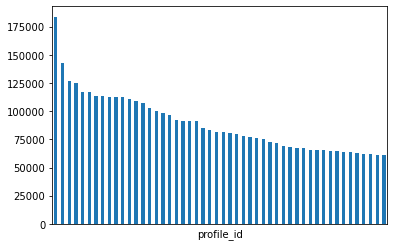

In [13]:
# RQ2_1_2.plot(x="profile_id", y="n_posts", kind="bar", xticks=[], legend=False)

--- EXPLORATORY DATA ANALYSIS (EDA) ---

In [46]:
### Locations dataset ###
#print(df_loc.shape)
#print(df_loc.isna().sum())

### Posts dataset ###
#print(df_posts.shape)
#print(df_posts.isna().sum())

### Profiles dataset ###
# print(df_prof.shape)
#print(df_prof.isna().sum())
# print(df_prof["followers"].max())
# print(df_prof["followers"].mean())

(4509586, 11)
285457645.0
4739.899180397426


In [ ]:
# RQ2_2
# RQ2_2 = df_posts[["post_id", "numbr_likes"]].copy()